In [1]:
import os
import pandas as pd
import kagglehub
from sklearn.feature_selection import SelectKBest,f_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [2]:
# Download dataset
path= kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")
print("Path to dataset files:", path)

# Check files
print("Files", os.listdir(path))

# Load dataset
csv_path= os.path.join(path, "loan_approval_dataset.csv")
df= pd.read_csv(csv_path)

# Dataset info
print("Dataset Shape::\n",df.shape)
print(df.head())
print("\nColumns:", df.columns)

# Check for duplicate and missing values
print("\nDuplicates:", df.duplicated().sum())
print("\nMissing Values:\n", df.isna().sum())

# Clean column names and check target variable counts and distribution
df.columns = df.columns.str.strip()

print("\nTarget Variable Count (numbers):")
print(df["loan_status"].value_counts())

print("\nTarget Variable Distribution (%):")
print((df["loan_status"].value_counts(normalize=True) * 100).round(2).astype(str) +'%')

Path to dataset files: C:\Users\Tasneem\.cache\kagglehub\datasets\architsharma01\loan-approval-prediction-dataset\versions\1
Files ['loan_approval_dataset.csv']
Dataset Shape::
 (4269, 13)
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467             

In [3]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Inspect their unique values
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

# Separate target before encoding
y=df['loan_status']
X= df.drop('loan_status', axis=1)

# Encode them automatically
X = pd.get_dummies(X, drop_first=True)

# Save the clean data

# Get current working directory (src/)
current_dir = os.getcwd()

# Move one level up to the project root
project_root = os.path.abspath(os.path.join(current_dir, os.pardir))

# Define the data folder path
data_dir = os.path.join(project_root, 'data')

# Make sure the data folder exists
os.makedirs(data_dir, exist_ok=True)

# Save the preprocessed dataset
output_path = os.path.join(data_dir, 'loan_approval_preprocessed.csv')
df.to_csv(output_path, index=False)

print(f"\nThe preprocessed data is saved successfully to:\n{output_path}")


education: [' Graduate' ' Not Graduate']
self_employed: [' No' ' Yes']
loan_status: [' Approved' ' Rejected']

The preprocessed data is saved successfully to:
c:\Users\Tasneem\OneDrive\Desktop\Loan_Approval_Prediction_Description\data\loan_approval_preprocessed.csv


Top Features based on ANOVA F-test:

                     Feature        Score
5                cibil_score  6235.054591
4                  loan_term    55.225458
1           no_of_dependents     1.400600
0                    loan_id     1.334967
3                loan_amount     1.113176
8        luxury_assets_value     1.020728
2               income_annum     0.984669
6   residential_assets_value     0.880877
7    commercial_assets_value     0.290152
9           bank_asset_value     0.196066
10   education_ Not Graduate     0.103202
11        self_employed_ Yes     0.000506


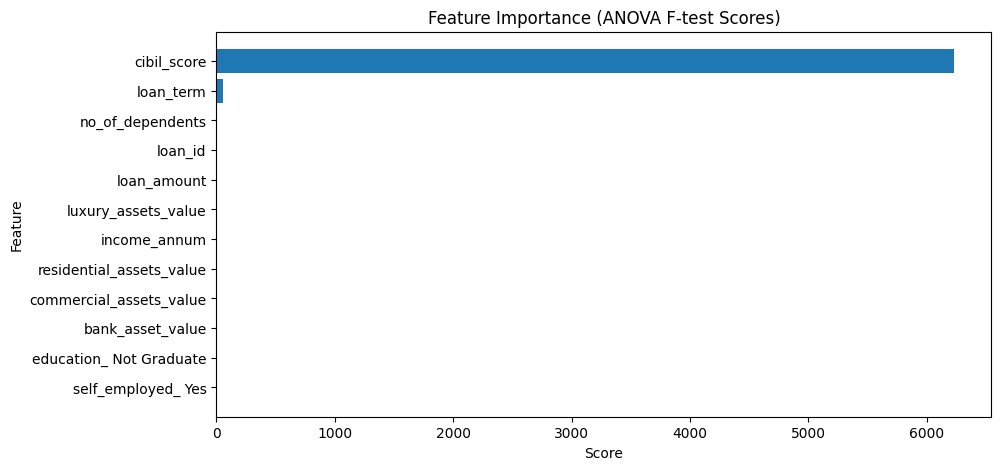

In [4]:
#Feature selection
# Apply ANOVA F-test
best_features= SelectKBest(score_func=f_classif, k=10)
fit= best_features.fit(X,y)

# Create a DataFrame with feature names and scores
df_scores= pd.DataFrame(fit.scores_, columns=['Score'])
df_columns= pd.DataFrame(X.columns, columns=['Feature'])
feature_scores= pd.concat([df_columns,df_scores], axis=1)

# Sort features by importance
feature_scores= feature_scores.sort_values(by='Score', ascending=False)

# Display results
print("Top Features based on ANOVA F-test:\n")
print(feature_scores)

# Visualize feature importance using ANOVA F-test scores
plt.figure(figsize=(10,5))
plt.barh(feature_scores['Feature'],feature_scores['Score'])
plt.gca().invert_yaxis()
plt.title('Feature Importance (ANOVA F-test Scores)') 
plt.xlabel('Score') 
plt.ylabel('Feature') 
plt.show()


In [5]:
# Update X to contain only the top features selected via ANOVA F-test
X= df[['cibil_score','loan_term']]

# Split the dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# Define models
models={
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42,max_depth=10)
}

results_imbalanced={}

# Train and evaluate models on imbalanced data
for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)

    results_imbalanced[name] = {
        "precision": precision_score(y_test, y_pred, average='weighted'),
        "recall": recall_score(y_test, y_pred, average='weighted'),
        "f1": f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print evaluation results
    print(name)
    print(f"Precision: {results_imbalanced[name]['precision']:.4f}")
    print(f"Recall:    {results_imbalanced[name]['recall']:.4f}")
    print(f"F1-Score:  {results_imbalanced[name]['f1']:.4f}\n")


Logistic Regression
Precision: 0.9261
Recall:    0.9262
F1-Score:  0.9259

Decision Tree
Precision: 0.9601
Recall:    0.9602
F1-Score:  0.9601



In [6]:
# Apply SMOTE on the training set to balance the dataset
smote= SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train,y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_smote.value_counts().to_dict())

results_smote={}

# Retrain and evaluate models on balanced data
for name, model in models.items():
    model.fit(X_train_smote,y_train_smote)
    y_pred_smote= model.predict(X_test)

    results_smote[name] = {
        "precision": precision_score(y_test, y_pred_smote, average='weighted'),
        "recall": recall_score(y_test, y_pred_smote, average='weighted'),
        "f1": f1_score(y_test, y_pred_smote, average='weighted')
    }
    
    # Print evaluation results
    print("\nAfter SMOTE -", name)
    print(f"Precision: {results_smote[name]['precision']:.4f}")
    print(f"Recall:    {results_smote[name]['recall']:.4f}")
    print(f"F1-Score:  {results_smote[name]['f1']:.4f}\n")


Before SMOTE: {' Approved': 2125, ' Rejected': 1290}
After SMOTE: {' Rejected': 2125, ' Approved': 2125}

After SMOTE - Logistic Regression
Precision: 0.9441
Recall:    0.9438
F1-Score:  0.9439


After SMOTE - Decision Tree
Precision: 0.9637
Recall:    0.9637
F1-Score:  0.9636



In [7]:
# Compare models before and after SMOTE
for model_name in models.keys():
    f1_imbalanced = results_imbalanced[model_name]["f1"]
    f1_smote = results_smote[model_name]["f1"]

    if f1_smote > f1_imbalanced:
        print(f"{model_name} improved after SMOTE (F1-Score: {f1_smote:.4f} > {f1_imbalanced:.4f})")
    else:
        print(f"{model_name} performed better on imbalanced data (F1-Score: {f1_smote:.4f} < {f1_imbalanced:.4f})")


Logistic Regression improved after SMOTE (F1-Score: 0.9439 > 0.9259)
Decision Tree improved after SMOTE (F1-Score: 0.9636 > 0.9601)


In [8]:
# Save evaluation results
results_df= pd.DataFrame({
    "Model": list(results_imbalanced.keys()),
    "Precision (Imbalanced)": [v['precision'] for v in results_imbalanced.values()],
    "Recall (Imbalanced)": [v['recall'] for v in results_imbalanced.values()],
    "F1-Score (Imbalanced)": [v['f1'] for v in results_imbalanced.values()],
    "Precision (Balanced)": [v['precision'] for v in results_smote.values()],
    "Recall (Balanced)": [v['recall'] for v in results_smote.values()],
    "F1-Score (Balanced)": [v['f1'] for v in results_smote.values()]
})

# Create results directory
results_dir = os.path.join(project_root, 'results')
os.makedirs(results_dir, exist_ok=True)

# Save results to CSV
results_path = os.path.join(results_dir, 'evaluation.csv')
results_df.to_csv(results_path, index=False)

print(f"Results saved successfully to:\n{results_path}")

Results saved successfully to:
c:\Users\Tasneem\OneDrive\Desktop\Loan_Approval_Prediction_Description\results\evaluation.csv


In [9]:
# Print which model performed best in both phases
best_model_imbalanced= max(results_imbalanced, key= lambda m: results_imbalanced[m]['f1'])
best_model_smote= max(results_smote, key= lambda m: results_smote[m]['f1'])

print("Best model on imbalanced data:", best_model_imbalanced)
print("Best model after SMOTE:", best_model_smote)

Best model on imbalanced data: Decision Tree
Best model after SMOTE: Decision Tree


In [10]:
# Identify the model with the highest SMOTE gain
improvements= {m: results_smote[m]['f1'] - results_imbalanced[m]['f1'] for m in models.keys()}
model_with_biggest_gain= max(improvements, key= improvements.get)

print("Model that improved the most after SMOTE:", model_with_biggest_gain)

Model that improved the most after SMOTE: Logistic Regression
